# Lesson 16 - Solutions

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Walmart Sales Data
For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:
- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

Sample:
```
Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.5,FALSE
```

### Loading the data and setting the DateTimeIndex

In [2]:
# one way: read first, set "Date" as index later
data = pd.read_csv("../../../../data/train.csv")
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace = True)
print("# one way: read first, set 'Date' as index later")
print(data.head())
del data

# another way (same effect as above): read and set index at the same time
data = pd.read_csv("../../../../data/train.csv",
                   index_col = "Date",
                   date_parser = lambda date: pd.to_datetime(date))
print("\n# another way (same effect as above): read and set index at the same time")
print(data.head())

# one way: read first, set 'Date' as index later
            Store  Dept  Weekly_Sales IsHoliday
Date                                           
2010-02-05      1     1      24924.50     False
2010-02-12      1     1      46039.49      True
2010-02-19      1     1      41595.55     False
2010-02-26      1     1      19403.54     False
2010-03-05      1     1      21827.90     False

# another way (same effect as above): read and set index at the same time
            Store  Dept  Weekly_Sales IsHoliday
Date                                           
2010-02-05      1     1      24924.50     False
2010-02-12      1     1      46039.49      True
2010-02-19      1     1      41595.55     False
2010-02-26      1     1      19403.54     False
2010-03-05      1     1      21827.90     False


### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [3]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data.Store == 1][["Weekly_Sales"]].resample("W").sum()
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


### Plot the `rolling_mean` for `Weekly_Sales`
- What general trends do you observe?

/Users/angeloklin/anaconda3/envs/ga/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  if __name__ == '__main__':


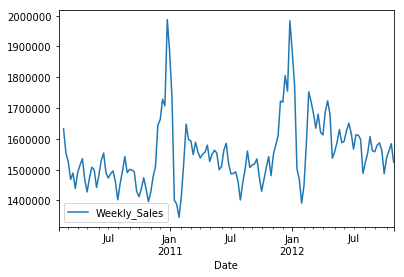

In [4]:
pd.rolling_mean(store1_sales[["Weekly_Sales"]], 3).plot()
plt.show()

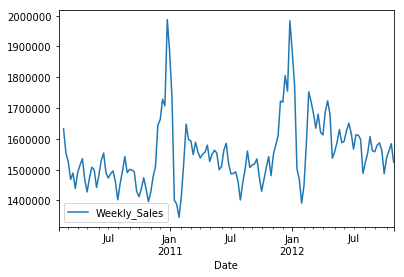

In [5]:
# New Syntax!
store1_sales[["Weekly_Sales"]].rolling(3).mean().plot()
plt.show()

### Compute the 1, 2, 52 `autocorrelations` for `Weekly_Sales` and/or create an autocorrelation plot

In [6]:
print("Autocorrelation  1: %f" % store1_sales["Weekly_Sales"].autocorr(1))
print("Autocorrelation  3: %f" % store1_sales["Weekly_Sales"].autocorr(3))
print("Autocorrelation 52: %f" % store1_sales["Weekly_Sales"].autocorr(52))

Autocorrelation  1: 0.302158
Autocorrelation  3: 0.059799
Autocorrelation 52: 0.895376


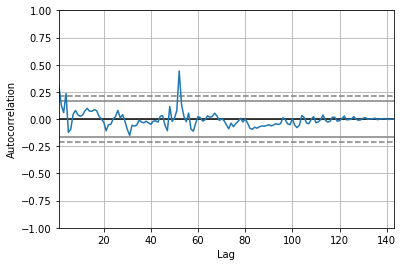

In [7]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales["Weekly_Sales"])
plt.show()

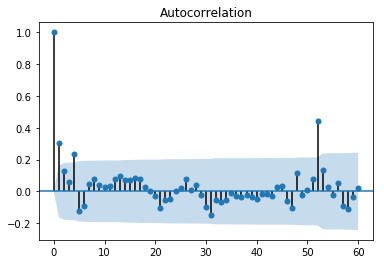

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales["Weekly_Sales"], lags = 60)
plt.show()

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

### Split the weekly sales data in a training and test set - using 75% of the data for training

In [9]:
n = len(store1_sales.Weekly_Sales)
divide = int(0.75 * n)

train = store1_sales.Weekly_Sales[:divide]
test = store1_sales.Weekly_Sales[divide:]

### Create an AR(1) model on the training data and compute the mean absolute error of the predictions

In [10]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [11]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    "2012-02-27",
    "2012-10-29",
    dynamic = True)

print("Mean absolute error: %f\n" % mean_absolute_error(test, predictions))
print(model.summary())

Mean absolute error: 81839.338632

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Thu, 23 Mar 2017   AIC                           2875.327
Time:                        11:24:54   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001         0

/Users/angeloklin/anaconda3/envs/ga/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


### Plot the residuals - where are their significant errors

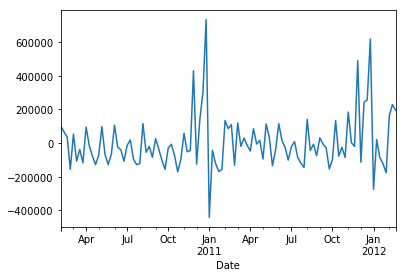

In [12]:
model.resid.plot()
plt.show()

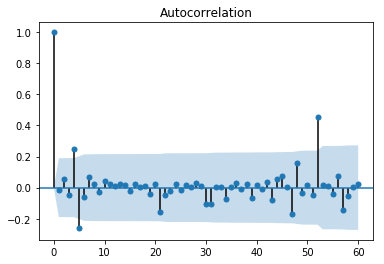

In [13]:
plot_acf(model.resid, lags = 60)
plt.show()

### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set

In [14]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    "2012-02-27",
    "2012-10-29",
    dynamic = True)

print("Mean absolute error: %f\n" % mean_absolute_error(test, predictions))
print(model.summary())

Mean absolute error: 81203.239532

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Thu, 23 Mar 2017   AIC                           2876.963
Time:                        11:24:54   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003         0

In [15]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    "2012-02-27",
    "2012-10-29",
    dynamic = True)

print("Mean absolute error: %f\n" % mean_absolute_error(test, predictions))
print(model.summary())

Mean absolute error: 80503.734456

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144104.008
Date:                Thu, 23 Mar 2017   AIC                           2863.563
Time:                        11:24:55   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.320      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0398      0.090    -11.583      0.000        -1

### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q and parameters comparing the model's performance

In [16]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    "2012-02-27",
    "2012-10-29",
    dynamic = False,
    typ = "levels")

print("Mean absolute error: %f\n" % mean_absolute_error(test, predictions))
print(model.summary())

Mean absolute error: 77861.871403

                             ARIMA Model Results                              
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.587
Method:                       css-mle   S.D. of innovations         142884.435
Date:                Thu, 23 Mar 2017   AIC                           2841.173
Time:                        11:24:55   BIC                           2859.817
Sample:                    02-14-2010   HQIC                          2848.730
                         - 02-19-2012                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  599.0033    619.665      0.967      0.336      -615.519  1813.525
ar.L1.D.Weekly_Sales    -1.0504      0.090    -11.632      0.000  

/Users/angeloklin/anaconda3/envs/ga/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
